MARASIGAN, Geremiah Zachary <b>11610611</b><br>
ONA, Ian <b>11614854</b>

In [99]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import scipy
from scipy import stats
import seaborn as sns
import geopandas as gpd
import math
sns.set(style="darkgrid")

from pathlib import Path

from statsmodels.stats.weightstats import ztest
from scipy.stats import chi2_contingency, ttest_1samp, ttest_ind
from scipy.stats import pearsonr, spearmanr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# The Philippines Under Fire
## An Exploration of Fire Incident Open Data
In this project, we plan to explore an existing open data set that details the fire incident statistics from 2012-2016. This dataset covers the number of fire incidents, fire incident injuries, deaths, and amount of estimated damages in Php, among others. By integrating this dataset with the datasets for current BFP & LGU firetrucks as well as the Internal Revenue Allotment (IRA), we hope to determine which factors affect the disaster preparedness of various areas in the Philippines.

Link for Fire Incident 2012-2016 Statistics dataset: https://data.gov.ph/dataset/bfp-nationwide-fire-incidents-statistics-cy-2012-2016
<br>Link for BFP & LGE Firetrucks dataset: https://data.gov.ph/dataset/bureau-fire-protection-bfp-and-local-government-unit-lgu-fire-trucks
<br>Link for IRA Dependency by Province dataset: https://data.gov.ph/dataset/internal-revenue-allotment-dependency
<br>Philippine shapefile: http://philgis.org/country-basemaps/country-boundary
<br>Metro Manila shapefile: http://philgis.org/province-page/metro-manila

## Preparing our Data

In [100]:
# First, we prepare our main dataset, BFP Fire Incidents
DSDATA = Path(os.getenv('DSDATA'))
file = DSDATA / 'BFP_FIreIncidents2012-2016.csv'
if file.exists():
    print('File exists!')
else:
    print('Please download file and place insisde DSDATA folder.')

File exists!


In [101]:
df = pd.read_csv(file, encoding='latin-1')
# Title case our provinces for easier merging with map later on
df['PROVINCE_FIRE_DISTRICT'] = df['PROVINCE_FIRE_DISTRICT'].apply(lambda x: x.title())

# Fix value for Las Pinas City and Paranaque City
df.loc[df['CITY_MUNICIPALITY'] == 'LAS PIãAS CITY', 'CITY_MUNICIPALITY'] = 'LAS PIÑAS CITY'
df.loc[df['CITY_MUNICIPALITY'] == 'PARAãAQUE CITY', 'CITY_MUNICIPALITY'] = 'PARAÑAQUE CITY'

# Check for any null values
df.isnull().values.any()

# No need to handle null values since none exist

False

In [102]:
# Column names for reference
print("FIRE DATA COLUMN NAMES")
list(df)

# Since all column names are already descriptive and properly formatted, no need to clean

FIRE DATA COLUMN NAMES


['PSGC',
 'REGION',
 'PROVINCE_FIRE_DISTRICT',
 'CONGRESSIONAL_DISTRICT',
 'CITY_MUNICIPALITY',
 'YEAR',
 'INCIDENTS',
 'INJURIES',
 'DEATHS',
 'ESTIMATED_DAMAGES']

In [103]:
# Column datatypes for reference
print("FIRE DATA COLUMN TYPES")
for col in df.columns:
  print(col + " : " + str(df[col].dtype))
 
# Since all data types are appropriate for each column, no need to clean

FIRE DATA COLUMN TYPES
PSGC : int64
REGION : object
PROVINCE_FIRE_DISTRICT : object
CONGRESSIONAL_DISTRICT : object
CITY_MUNICIPALITY : object
YEAR : int64
INCIDENTS : int64
INJURIES : int64
DEATHS : int64
ESTIMATED_DAMAGES : float64


In [104]:
# Next, we prepare supplemetary datasets (BFP Firetrucks & Internal Revenue Allotment)
ira_file = DSDATA / '2009-2014_irad_by_province.csv'
firetrucks_file = DSDATA / 'bfp_firetrucks.csv'
if ira_file.exists() and firetrucks_file.exists():
    print('Files exists!')
else:
    print('Please download files and place insisde DSDATA folder.')

Files exists!


In [105]:
df2 = pd.read_csv(firetrucks_file, encoding='latin-1')

# Capitalize column names for uniformity
df2.columns = [col.upper() for col in df2.columns]

# Title case our provinces for easier merging with map later on
df2['PROVINCE'] = df2['PROVINCE'].apply(lambda x: x.title())

df2.isnull().values.any()
# No null data for now, but we will check again later after cleaning

False

In [106]:
# Column names for reference
print("FIRETRUCK COLUMN NAMES")
list(df2)

# Since all column names are already descriptive and properly formatted, no need to clean

FIRETRUCK COLUMN NAMES


['TRUCK_ID',
 'REGION',
 'PROVINCE',
 'CONGRESSIONAL_DISTRICT',
 'CITY_OR_MUNICIPALITY',
 'STATION_NAME',
 'VEHICLE_MODEL',
 'VEHICLE_TYPE',
 'VEHICLE_CAPACITY',
 'VEHICLE_STATUS',
 'VEHICLE_OWNER',
 'PLATE_NUMBER',
 'ENGINE_NUMBER',
 'CHASSIS_NUMBER',
 'ACQUISITION_COST',
 'MANUFACTURE_DATE',
 'MANUFACTURE_AGE',
 'ACQUISITION_DATE',
 'ACQUISITION_AGE',
 'REMARKS']

In [107]:
# Fix incorrect data types
df2['VEHICLE_CAPACITY'] = pd.to_numeric(df2['VEHICLE_CAPACITY'], errors='coerce', downcast='integer')
df2['MANUFACTURE_DATE'] = pd.to_numeric(df2['MANUFACTURE_DATE'], errors='coerce', downcast='integer')
df2['MANUFACTURE_AGE'] = pd.to_numeric(df2['MANUFACTURE_AGE'], errors='coerce', downcast='integer')
df2['ACQUISITION_DATE'] = pd.to_numeric(df2['ACQUISITION_DATE'], errors='coerce', downcast='integer')
df2['ACQUISITION_AGE'] = pd.to_numeric(df2['ACQUISITION_AGE'], errors='coerce', downcast='integer')
if df2['ACQUISITION_COST'].dtype != "float64":
    df2['ACQUISITION_COST'] = df2['ACQUISITION_COST'].str.replace('PhP', '')
    df2['ACQUISITION_COST'] = df2['ACQUISITION_COST'].str.replace(',', '')
    df2['ACQUISITION_COST'] = pd.to_numeric(df2['ACQUISITION_COST'], errors='coerce')

# Column datatypes for reference
print("FIRETRUCK COLUMN DATA TYPES")
for col in df2.columns:
    print(col + " : " + str(df2[col].dtype))

# Since there are null values now, we have to handle them
df2.fillna(0, inplace=True)

FIRETRUCK COLUMN DATA TYPES
TRUCK_ID : int64
REGION : object
PROVINCE : object
CONGRESSIONAL_DISTRICT : object
CITY_OR_MUNICIPALITY : object
STATION_NAME : object
VEHICLE_MODEL : object
VEHICLE_TYPE : object
VEHICLE_CAPACITY : float64
VEHICLE_STATUS : object
VEHICLE_OWNER : object
PLATE_NUMBER : object
ENGINE_NUMBER : object
CHASSIS_NUMBER : object
ACQUISITION_COST : float64
MANUFACTURE_DATE : float64
MANUFACTURE_AGE : float64
ACQUISITION_DATE : float64
ACQUISITION_AGE : float64
REMARKS : object


In [108]:
df3 = pd.read_csv(ira_file, encoding='latin-1')

# Capitalize column names for uniformity
df3.columns = [col.upper() for col in df3.columns]

df3.isnull().values.any()
# No null data for now, but we will check again later after cleaning

False

In [109]:
# Column names for reference
print("IRA COLUMN NAMES")
list(df3)

# Since all column names are already descriptive and properly formatted, no need to clean

IRA COLUMN NAMES


['REGION', 'PROVINCE', '2009', '2010', '2011', '2012', '2013', '2014']

In [110]:
# Fix incorrect data types
df3['2013'] = pd.to_numeric(df3['2013'], errors='coerce', downcast='integer')
df3['2013'].fillna(0, inplace = True)
df3['2013'] = pd.Series(df3['2013']).astype(int)
# Column datatypes for reference
print("IRA COLUMN DATA TYPES")
for col in df3.columns:
    print(col + " : " + str(df3[col].dtype))

IRA COLUMN DATA TYPES
REGION : object
PROVINCE : object
2009 : int64
2010 : int64
2011 : int64
2012 : int64
2013 : int64
2014 : int64


## Preliminary Visualizations and Descriptive Statistics
For initial visualizations we will first be visualizing the distribution of the dataset on the values for Incidents, Injuries, and Deaths. We will also be visualizing the mean number of incidents by region to provide insight on which region experiences the most fire incidents on average.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


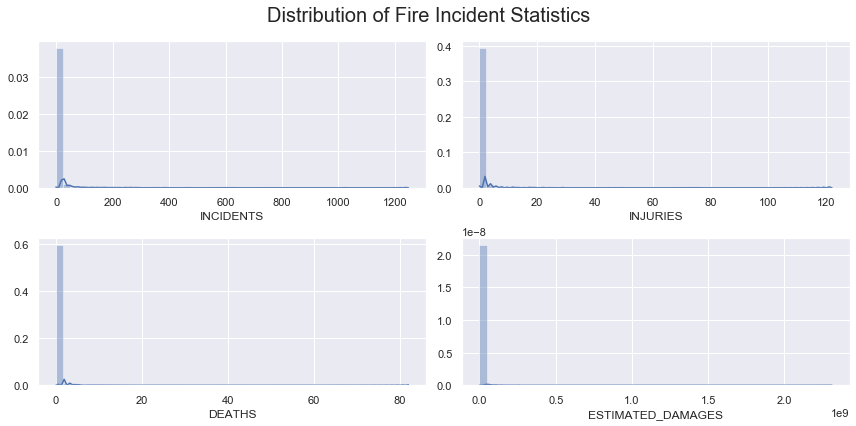

In [111]:
# Distribution of all columns
fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(ncols=2, nrows=2, figsize=(12,6))

sns.distplot(df["INCIDENTS"], ax=ax1)
sns.distplot(df["INJURIES"], ax=ax2);
sns.distplot(df["DEATHS"], ax=ax3);
sns.distplot(df["ESTIMATED_DAMAGES"], ax=ax4);
fig.suptitle("Distribution of Fire Incident Statistics", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

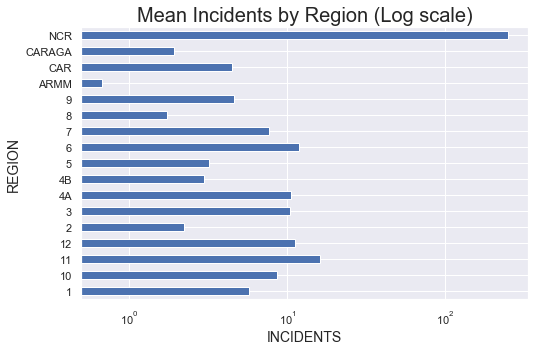

In [112]:
# Visualize mean number of incidents per region
fig = plt.figure(figsize(8,5))
group_category = df.groupby('REGION')['INCIDENTS'].apply(lambda x: x.mean())
group_category.plot.barh()
plt.title('Mean Incidents by Region (Log scale)', fontsize=20)
plt.xlabel("INCIDENTS", fontsize=14)
plt.ylabel("REGION", fontsize=14)
plt.xscale('log')
plt.show()

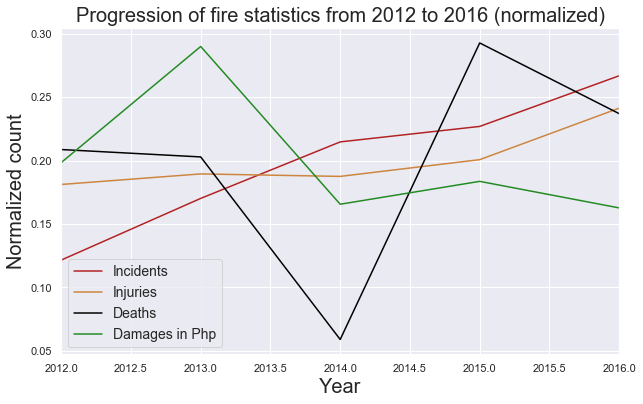

In [113]:
fig = plt.figure(figsize(10,6))
years = [2012,2013,2014,2015,2016]

incidents = df['INCIDENTS'].groupby(df['YEAR']).sum()
injuries = df['INJURIES'].groupby(df['YEAR']).sum()
deaths = df['DEATHS'].groupby(df['YEAR']).sum()
damages = df['ESTIMATED_DAMAGES'].groupby(df['YEAR']).sum()
# pd.to_datetime(incidents.YEAR, format='%Y')
ax = (incidents/incidents.sum()).plot(kind='line', color='firebrick', label='Incidents')
ax = (injuries/injuries.sum()).plot(kind='line', color='peru', label='Injuries')
ax = (deaths/deaths.sum()).plot(kind='line', color='black', label='Deaths')
ax = (damages/damages.sum()).plot(kind='line', color='forestgreen', label='Damages in Php')


# ax.xaxis.set_ticklabels(years, rotation=30)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Normalized count', fontsize=20)
plt.legend(fontsize=14)
ax.set_title('Progression of fire statistics from 2012 to 2016 (normalized)', fontsize=20);

### Findings (Initial Visualizations)
The distributions of the different columns in the fire incident data set are all skewed to the right, indicating that majority of the values fall to the right of the distribution's peak. The mean number of incidents in NCR greatly outnumber all other regions which makes it an outlier. A log scale is used to provide a better visualization to the data, however, this means that the values _______________. For the progression of fire statistics, no clear trend can be observed among the number of deaths and amount of estimated damages through the years. However, there is a steady increase in the number of fire incidents and fire injuries, indicating a somewhat worsening fire situation in the country.

## Map Visualizations
To provide more comprehensive insight on which areas are affected the most by fire incidents, the following visualizations will consist of geospatial information as to easier pinpoint our areas of interest.

Since we saw from the previous table that the incident statistics for NCR is incredibly high compared to the other regions, for the map visualizations to be more insightful, we will be creating a separate visualization for Metro Manila before proceeding to the rest of the country.

In [114]:
mm = gpd.read_file(DSDATA / 'MetroManilaBoundaries/MetroManilaBoundaries.shp')
mm['name'] = mm['name'].str.upper()

# Study the possible merging that can be done between Metro Manila shape file and the fire incident dataset
for city in mm['name']:
    if 'CITY' not in city and city != 'PATEROS':
        mm.loc[mm['name'] == city, 'name'] = city + ' CITY'
        city += ' CITY'
    print(city)
    print(df.loc[df['CITY_MUNICIPALITY'] == city]['CITY_MUNICIPALITY'])
    print("------")

SAN JUAN CITY
8155    SAN JUAN CITY
8156    SAN JUAN CITY
8157    SAN JUAN CITY
8158    SAN JUAN CITY
8159    SAN JUAN CITY
Name: CITY_MUNICIPALITY, dtype: object
------
MANDALUYONG CITY
8135    MANDALUYONG CITY
8136    MANDALUYONG CITY
8137    MANDALUYONG CITY
8138    MANDALUYONG CITY
8139    MANDALUYONG CITY
Name: CITY_MUNICIPALITY, dtype: object
------
LAS PIÑAS CITY
8110    LAS PIÑAS CITY
8111    LAS PIÑAS CITY
8112    LAS PIÑAS CITY
8113    LAS PIÑAS CITY
8114    LAS PIÑAS CITY
Name: CITY_MUNICIPALITY, dtype: object
------
MUNTINLUPA CITY
8120    MUNTINLUPA CITY
8121    MUNTINLUPA CITY
8122    MUNTINLUPA CITY
8123    MUNTINLUPA CITY
8124    MUNTINLUPA CITY
Name: CITY_MUNICIPALITY, dtype: object
------
MALABON CITY
8095    MALABON CITY
8096    MALABON CITY
8097    MALABON CITY
8098    MALABON CITY
8099    MALABON CITY
Name: CITY_MUNICIPALITY, dtype: object
------
NAVOTAS CITY
8100    NAVOTAS CITY
8101    NAVOTAS CITY
8102    NAVOTAS CITY
8103    NAVOTAS CITY
8104    NAVOTAS CITY
Na

In [115]:
# Create an aggregated dataset by city Metro Manila
df_mm = df.groupby('CITY_MUNICIPALITY').aggregate({'INCIDENTS':'mean',
                                                        'INJURIES':'mean',
                                                        'DEATHS':'mean',
                                                        'ESTIMATED_DAMAGES':'mean'})
df_mm.reset_index(level=0, inplace=True)
df_mm = df_mm[df_mm['CITY_MUNICIPALITY'].isin(mm['name'].tolist())]

# Since we fixed the city names, they can now be used as basis for merging
merged_mm = mm.merge(df_mm,left_on='name',right_on='CITY_MUNICIPALITY')

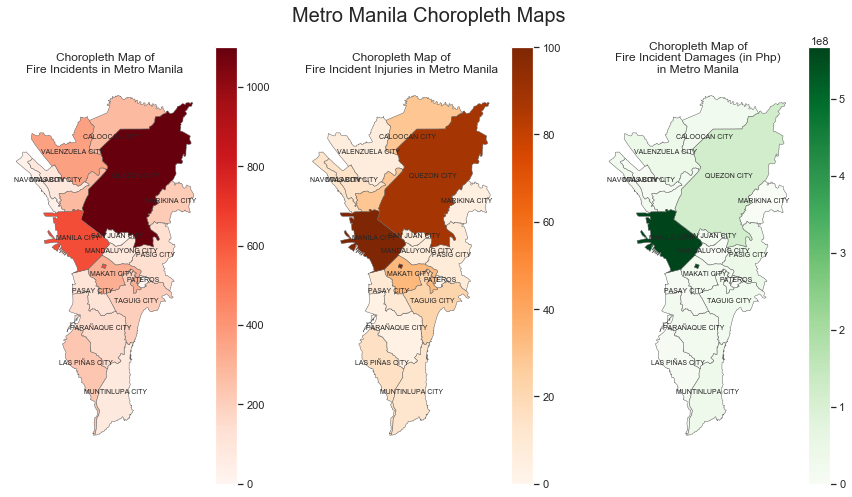

In [116]:
# After merging, we can now plot the data
# We explore number of incidents, injuries, and estimated damages due to fire throughout Metro Manila
fig, (ax1, ax2, ax3) = pyplot.subplots(ncols=3, figsize=(12, 7), sharex=True, sharey=True)

# Incidents
variable1 = 'INCIDENTS'
vmin1, vmax1 = 0, int(math.ceil((merged_mm[variable1].max()) / 100.0)) * 100
merged_mm.plot(column=variable1, cmap='Reds', linewidth=0.5, ax=ax1, edgecolor='0.4')
ax1.axis('off')
ax1.set_title("Choropleth Map of\nFire Incidents in Metro Manila")

sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin1, vmax=vmax1))
sm1._A = []
cbar = fig.colorbar(sm1, ax=ax1)

# Injuries
variable2 = 'INJURIES'
vmin2, vmax2 = 0, int(math.ceil((merged_mm[variable2].max()) / 100.0)) * 100
merged_mm.plot(column=variable2, cmap='Oranges', linewidth=0.5, ax=ax2, edgecolor='0.4')
ax2.axis('off')
ax2.set_title("Choropleth Map of\nFire Incident Injuries in Metro Manila")

sm2 = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
sm2._A = []
cbar = fig.colorbar(sm2, ax=ax2)

# Estimated Damages
variable3 = 'ESTIMATED_DAMAGES'
vmin3, vmax3 = 0, int(math.ceil((merged_mm[variable3].max()) / 100.0)) * 100
merged_mm.plot(column=variable3, cmap='Greens', linewidth=0.5, ax=ax3, edgecolor='0.4')
ax3.axis('off')
ax3.set_title("Choropleth Map of\nFire Incident Damages (in Php)\nin Metro Manila")

sm3 = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin3, vmax=vmax3))
sm3._A = []
cbar = fig.colorbar(sm3, ax=ax3)

merged_mm.apply(lambda x: ax1.annotate(s=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1)
merged_mm.apply(lambda x: ax2.annotate(s=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1)
merged_mm.apply(lambda x: ax3.annotate(s=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1)
fig.suptitle("Metro Manila Choropleth Maps", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

In [117]:
# Load shape file for the Philippine map
ph = gpd.read_file(DSDATA / 'gadm36_PHL_shp/gadm36_PHL_2.shp')
ph = ph[['NAME_1','geometry']]
ph.head()

,NAME_1,geometry
0,Abra,"POLYGON ((120.62709808 17.49300003, 120.621772..."
1,Abra,"POLYGON ((120.99041748 17.39801979, 120.986312..."
2,Abra,"POLYGON ((120.70787811 17.45395088, 120.706207..."
3,Abra,"POLYGON ((120.78955841 17.41699028, 120.789222..."
4,Abra,"POLYGON ((120.9291687 17.41307068, 120.9246368..."


In [118]:
# Since the dataset we are working with is aggregated by provincial fire district,
# we want to aggregate our map by province as well
ph_by_province = ph.dissolve(by='NAME_1', aggfunc='sum')
ph_by_province.head()

,geometry
NAME_1,
Abra,"POLYGON ((120.77472687 17.1631794, 120.7663726..."
Agusan del Norte,"POLYGON ((125.4462738 8.66631031, 125.44199371..."
Agusan del Sur,"POLYGON ((126.04052734 7.93676996, 126.0383834..."
Aklan,"(POLYGON ((122.4366684 11.59832954, 122.436668..."
Albay,"(POLYGON ((123.28764343 13.04922962, 123.28685..."


In [119]:
# We want to find discrepancies in the province list before we merge the fire incidents into the map
# To do that, we find elements in both lists that are unique and see what we can do
provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_map = ph['NAME_1'].unique().tolist()
tofix = list(set(provinces_map)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_map))
print(tofix)

# Findings:
# We can merge cases like Agusan del Norte and Agusan Del Norte (they differ in one character)
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Zamboanga Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Zamboanga del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Zamboanga Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Zamboanga del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Agusan Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Agusan del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Agusan Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Agusan del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Lanao Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Lanao del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Lanao Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Lanao del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Davao Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Davao del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Davao Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Davao del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Surigao Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Surigao del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Surigao Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Surigao del Norte'
# We can map all Districts (from the BFP dataset) to Metropolitan Manila (in the map) as they pertain to
# different districts within NCR
df.loc[df['PROVINCE_FIRE_DISTRICT'].str.contains('District'), 'PROVINCE_FIRE_DISTRICT'] = 'Metropolitan Manila'
# We can merge cases such as North Cotabato and Cotabato (North Cotabato)
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Cotabato (North Cotabato)', 'PROVINCE_FIRE_DISTRICT'] = 'North Cotabato'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Samar (Western Samar)', 'PROVINCE_FIRE_DISTRICT'] = 'Samar'

provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_map = ph['NAME_1'].unique().tolist()
tofix = list(set(provinces_map)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_map))
print(tofix)

['Agusan del Sur', 'Surigao del Sur', 'Surigao del Norte', 'Metropolitan Manila', 'Zamboanga del Sur', 'Lanao del Norte', 'Lanao del Sur', 'Davao del Sur', 'Davao del Norte', 'Agusan del Norte', 'Zamboanga del Norte', 'Samar', 'North Cotabato', '/////', 'Davao Del Sur', 'District Iv', 'Samar (Western Samar)', 'District Iii', 'Lanao Del Norte', 'Davao Del Norte', 'District V', 'Surigao Del Norte', 'Zamboanga Del Norte', 'Agusan Del Sur', 'Lanao Del Sur', 'Cotabato (North Cotabato)', 'Surigao Del Sur', 'Zamboanga Del Sur', 'Agusan Del Norte', 'District Ii', 'Davao Occidental', 'District I']
['/////', 'Davao Occidental']


In [120]:
# We want to visualize the data for 2016 first
df_2016 = df.loc[df['YEAR'] == 2016]
df_2016 = df_2016.groupby('PROVINCE_FIRE_DISTRICT').aggregate({'INCIDENTS':'sum',
                                                               'INJURIES':'sum',
                                                               'DEATHS':'sum',
                                                               'ESTIMATED_DAMAGES':'sum'})
df_2016.reset_index(level=0, inplace=True)

# Since we fixed the names of the provinces in the dataframe, they can now be used as basis for merging
merged = ph_by_province.merge(df_2016,left_on='NAME_1',right_on='PROVINCE_FIRE_DISTRICT')

# Metro Manila fire stats is way higher than anywhere else, uncomment the line below to drop it and 
# visualize the other places in comparison with each other because the way it is now, it just looks
# like Metro Manila is the only place of interest (kinda like an outlier)
merged = merged.drop(merged.loc[merged['PROVINCE_FIRE_DISTRICT']=='Metropolitan Manila'].index)

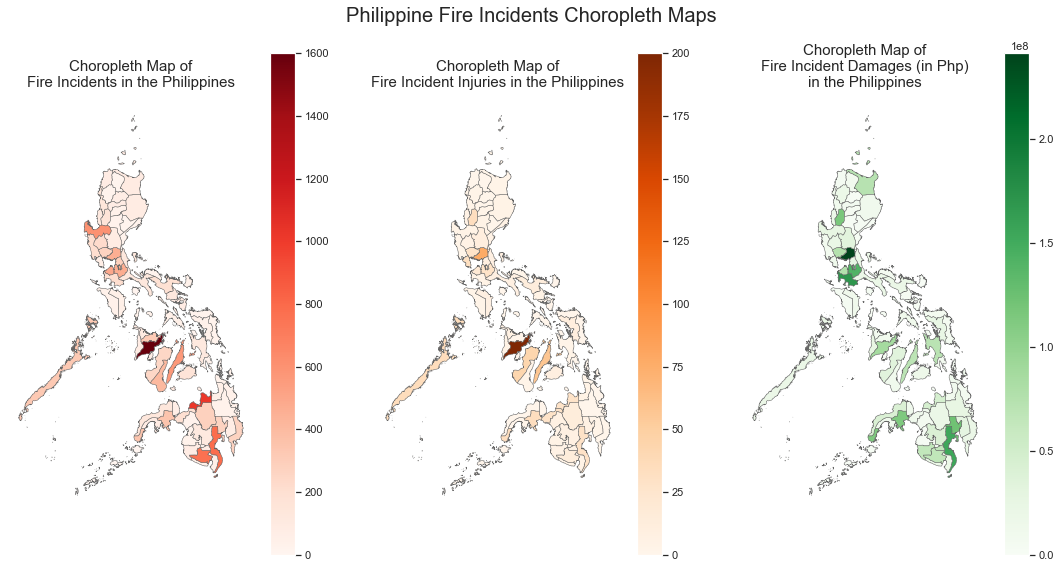

In [121]:
# After merging, we can now plot the data
# We explore number of incidents, injuries, and estimated damages due to fire throughout the Philippines
fig, (ax1, ax2, ax3) = pyplot.subplots(ncols=3, figsize=(15, 8), sharex=True, sharey=True)

# We can plot now that the data is merged into the map
# First, we explore number of incidents throughout the country
variable1 = 'INCIDENTS'
vmin1, vmax1 = 0, int(math.ceil((merged[variable1].max()) / 100.0)) * 100
merged.plot(column=variable1, cmap='Reds', linewidth=0.5, ax=ax1, edgecolor='0.4')
ax1.axis('off')
ax1.set_title("Choropleth Map of\nFire Incidents in the Philippines", fontsize=15)

sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin1, vmax=vmax1))
sm1._A = []
cbar = fig.colorbar(sm1, ax=ax1)

# Injuries
variable2 = 'INJURIES'
vmin2, vmax2 = 0, int(math.ceil((merged[variable2].max()) / 100.0)) * 100
merged.plot(column=variable2, cmap='Oranges', linewidth=0.5, ax=ax2, edgecolor='0.4')
ax2.axis('off')
ax2.set_title("Choropleth Map of\nFire Incident Injuries in the Philippines", fontsize=15)

sm2 = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
sm2._A = []
cbar = fig.colorbar(sm2, ax=ax2)

# Estimated Damages
variable3 = 'ESTIMATED_DAMAGES'
vmin3, vmax3 = 0, int(math.ceil((merged[variable3].max()) / 100.0)) * 100
merged.plot(column=variable3, cmap='Greens', linewidth=0.5, ax=ax3, edgecolor='0.4')
ax3.axis('off')
ax3.set_title("Choropleth Map of\nFire Incident Damages (in Php)\nin the Philippines", fontsize=15)

sm3 = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin3, vmax=vmax3))
sm3._A = []
cbar = fig.colorbar(sm3, ax=ax3)

# merged.apply(lambda x: ax1.annotate(s=x['PROVINCE_FIRE_DISTRICT'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1)
# merged.apply(lambda x: ax2.annotate(s=x['PROVINCE_FIRE_DISTRICT'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1)
# merged.apply(lambda x: ax3.annotate(s=x['PROVINCE_FIRE_DISTRICT'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1)
fig.suptitle("Philippine Fire Incidents Choropleth Maps", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

### Findings (Choropleth Visualizations)
For the Metro Manila choropleths, Quezon City leads in the number of fire incidents with Manila coming in second. Interestingly however, Manila suffers from slightly more fire injuries than Quezon City and also greatly surpasses Quezon in amount of estimated damages in Php. This could be due to the infrastructure and population density in Manila which is more than twice that of Quezon.

For the choropleth maps of the rest of the country, provinces which lead in the number of fire incidents, injuries, and estimated damages are Iloilo, Bulacan, Davao, Batangas, Laguna, and Misamis. This could be caused by the higher property value in these areas as they are known to be developed areas with higher urbanization outside of Metro Manila. Another interesting finding is that even though areas in Visayas and Mindanao are more prone to experiencing fire incidents, it is areas in Luzon that still experience a greater loss in pesos due to estimated fire damages.

## Identifying Possible Correlations
Next, we will be trying to find variables that have possible correlations. We will be using scatter plots to determine possible correlations within the Fire Incidents dataset. We will also be cross referencing other datasets such as the Internal Revenue Allotment and BFP Firetruck Information to determine possible correlations between fire incidents and local government budget as well as fire incidents and fire truck placement.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Injuries')

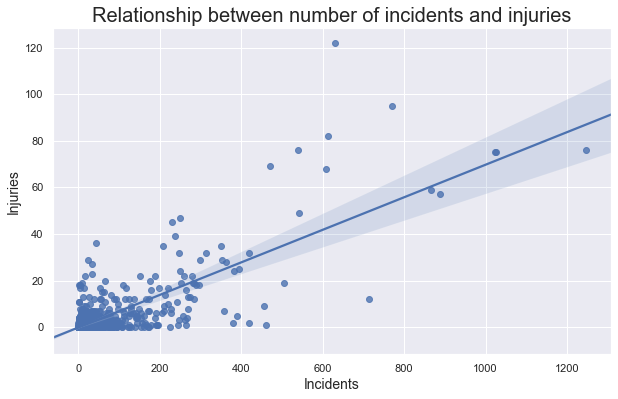

In [122]:
# Scatter plot of injuries vs incidents
sp = sns.regplot(df['INCIDENTS'], df['INJURIES'])
sp.set_title('Relationship between number of incidents and injuries', fontsize=20)
sp.set_xlabel("Incidents", fontsize=14)
sp.set_ylabel("Injuries", fontsize=14)

### Findings (Initial Scatterplot)
From the scatterplot above, it is evident that there exists a correlation between the number of incidents and the number of injuries, which is expected as a higher amount of fire incidents leads to more chances of experiencing injuries during these incidents.

In [123]:
# Before merging fire truck dataset with df_2016, we must fix the naming for the provinces
provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df2 = df2['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df2)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df2))
print(tofix)

# Findings:
# We can merge cases like Agusan del Norte and Agusan Del Norte (they differ in one character)
df2.loc[df2['PROVINCE'] == 'Zamboanga Del Sur', 'PROVINCE'] = 'Zamboanga del Sur'
df2.loc[df2['PROVINCE'] == 'Zamboanga Del Norte', 'PROVINCE'] = 'Zamboanga del Norte'
df2.loc[df2['PROVINCE'] == 'Agusan Del Sur', 'PROVINCE'] = 'Agusan del Sur'
df2.loc[df2['PROVINCE'] == 'Agusan Del Norte', 'PROVINCE'] = 'Agusan del Norte'
df2.loc[df2['PROVINCE'] == 'Lanao Del Sur', 'PROVINCE'] = 'Lanao del Sur'
df2.loc[df2['PROVINCE'] == 'Lanao Del Norte', 'PROVINCE'] = 'Lanao del Norte'
df2.loc[df2['PROVINCE'] == 'Davao Del Sur', 'PROVINCE'] = 'Davao del Sur'
df2.loc[df2['PROVINCE'] == 'Davao Del Norte', 'PROVINCE'] = 'Davao del Norte'
df2.loc[df2['PROVINCE'] == 'Surigao Del Sur', 'PROVINCE'] = 'Surigao del Sur'
df2.loc[df2['PROVINCE'] == 'Surigao Del Norte', 'PROVINCE'] = 'Surigao del Norte'
# We can map all Districts (from the BFP dataset) to Metropolitan Manila (in the map) as they pertain to
# different districts within NCR
df2.loc[df2['PROVINCE'].str.contains('District'), 'PROVINCE'] = 'Metropolitan Manila'
# We can merge cases such as North Cotabato and Cotabato (North Cotabato)
df2.loc[df2['PROVINCE'] == 'Cotabato (North Cotabato)', 'PROVINCE'] = 'North Cotabato'
df2.loc[df2['PROVINCE'] == 'Samar (Western Samar)', 'PROVINCE'] = 'Samar'

provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df2 = df2['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df2)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df2))
print(tofix)

['Davao Del Sur', 'District Iv', 'Samar (Western Samar)', 'District Iii', 'Lanao Del Norte', 'Davao Del Norte', 'District V', 'Surigao Del Norte', 'Zamboanga Del Norte', 'Agusan Del Sur', 'Lanao Del Sur', 'Cotabato (North Cotabato)', 'Surigao Del Sur', 'Zamboanga Del Sur', 'Agusan Del Norte', 'District Ii', 'District I', '/////', 'Zamboanga del Norte', 'Surigao del Sur', 'Surigao del Norte', 'Zamboanga del Sur', 'Metropolitan Manila', 'Lanao del Norte', 'Lanao del Sur', 'Davao del Sur', 'Davao del Norte', 'Agusan del Norte', 'Agusan del Sur', 'Samar', 'North Cotabato']
['/////']


In [124]:
# Next, we aggregate the firetruck dataset by province
df2_aggregated = df2.groupby('PROVINCE').aggregate({'VEHICLE_MODEL':'count',
                                                    'VEHICLE_CAPACITY':'mean',
                                                    'ACQUISITION_COST':'mean',
                                                    'ACQUISITION_AGE':'mean'})
df2_aggregated = df2_aggregated.rename({'VEHICLE_MODEL':'VEHICLES'},axis=1)
df2_aggregated.reset_index(level=0, inplace=True)
df2_aggregated.head()

,PROVINCE,VEHICLES,VEHICLE_CAPACITY,ACQUISITION_COST,ACQUISITION_AGE
0,Abra,14,750.000000,3.932930e+06,10.000000
1,Agusan del Norte,25,1062.840000,2.528771e+06,17.920000
2,Agusan del Sur,26,899.961538,2.458881e+06,9.153846
3,Aklan,18,819.444444,2.563025e+06,17.388889
4,Albay,34,1014.705882,4.025598e+06,17.647059


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


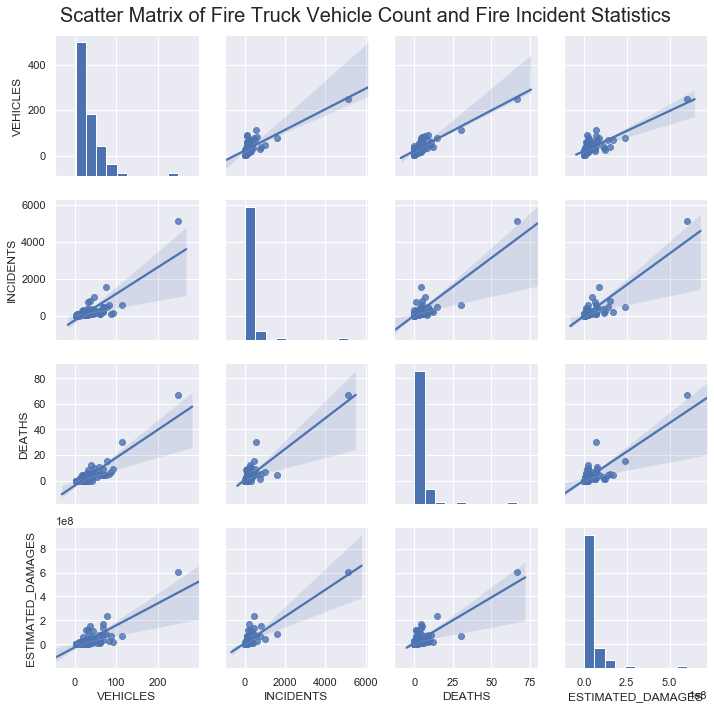

In [125]:
# Now we can merge the firetruck dataset with the fire incident data from 2016
merged_firetruck = df_2016.merge(df2_aggregated,left_on='PROVINCE_FIRE_DISTRICT',right_on='PROVINCE')

# We now use scatterplot visualizations to observe possible correlations between 
# number, age, cost of fire trucks with fire incident statistics

# First, we look at the relation of the number of firetruck to fire incident statistics
pp = sns.pairplot(merged_firetruck[['VEHICLES', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],kind="reg")
pp.fig.suptitle("Scatter Matrix of Fire Truck Vehicle Count and Fire Incident Statistics",fontsize=20)
pp.fig.subplots_adjust(top=0.94)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


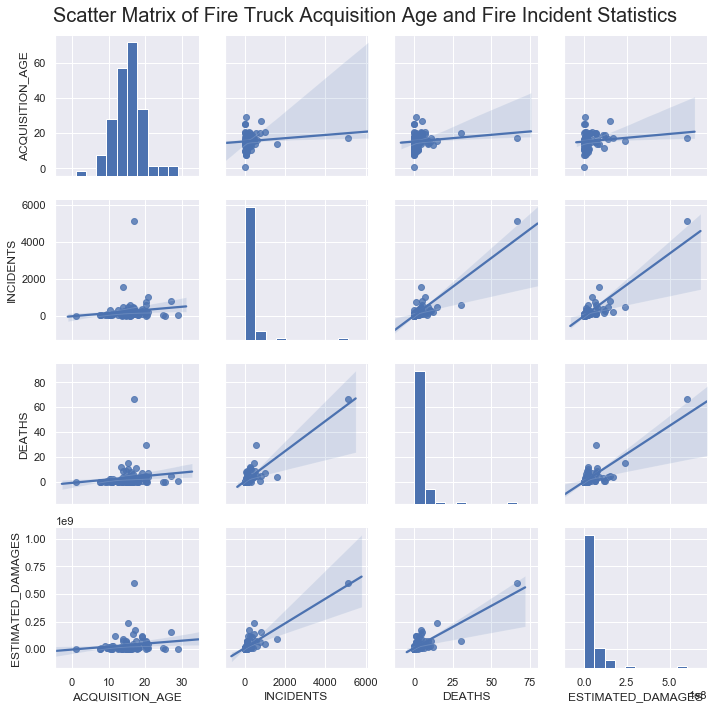

In [126]:
# Next, the age of the firetrucks with the fire incident statistics
pp = sns.pairplot(merged_firetruck[['ACQUISITION_AGE', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],kind="reg")
pp.fig.suptitle("Scatter Matrix of Fire Truck Acquisition Age and Fire Incident Statistics",fontsize=20)
pp.fig.subplots_adjust(top=0.94)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


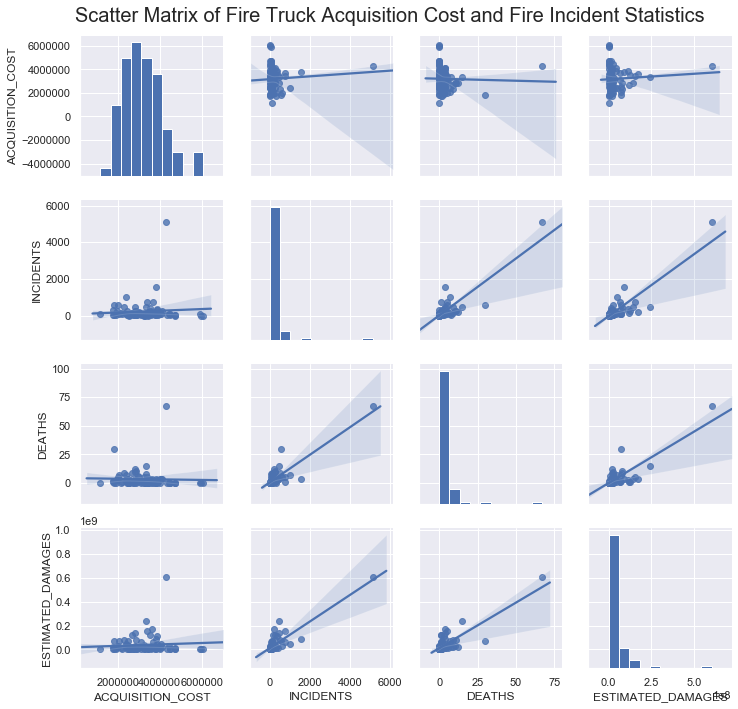

In [127]:
# Lastly, the cost of the firetrucks with the fire incident statistics
pp = sns.pairplot(merged_firetruck[['ACQUISITION_COST', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],kind="reg")
pp.fig.suptitle("Scatter Matrix of Fire Truck Acquisition Cost and Fire Incident Statistics",fontsize=20)
pp.fig.subplots_adjust(top=0.94)

### Findings (Firetruck Data vs Fire Incident Data)
For the latter 2 scatter matrices, it is evident that no direct correlation exists between the age of the firetrucks and the fire incident statistics as well as the cost of the firetrucks and the fire incident statistics. However, the first scatter plot shows evidence of what could be a correlation between the number of fire trucks and the fire incident statistics. Statistical testing will be done later on to confirm or deny this.

In [128]:
# Before merging IRA dataset with df_2016, we must fix the naming for the provinces
provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df3 = df3['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df3)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df3))
print(tofix)

# Findings:
# We can merge cases like Agusan del Norte and Agusan Del Norte (they differ in one character)
df3.loc[df3['PROVINCE'] == 'Zamboanga Del Sur', 'PROVINCE'] = 'Zamboanga del Sur'
df3.loc[df3['PROVINCE'] == 'Zamboanga Del Norte', 'PROVINCE'] = 'Zamboanga del Norte'
df3.loc[df3['PROVINCE'] == 'Agusan Del Sur', 'PROVINCE'] = 'Agusan del Sur'
df3.loc[df3['PROVINCE'] == 'Agusan Del Norte', 'PROVINCE'] = 'Agusan del Norte'
df3.loc[df3['PROVINCE'] == 'Lanao Del Sur', 'PROVINCE'] = 'Lanao del Sur'
df3.loc[df3['PROVINCE'] == 'Lanao Del Norte', 'PROVINCE'] = 'Lanao del Norte'
df3.loc[df3['PROVINCE'] == 'Davao Del Sur', 'PROVINCE'] = 'Davao del Sur'
df3.loc[df3['PROVINCE'] == 'Davao Del Norte', 'PROVINCE'] = 'Davao del Norte'
df3.loc[df3['PROVINCE'] == 'Surigao Del Sur', 'PROVINCE'] = 'Surigao del Sur'
df3.loc[df3['PROVINCE'] == 'Surigao Del Norte', 'PROVINCE'] = 'Surigao del Norte'
df3.loc[df3['PROVINCE'] == 'Western Samar (Samar)', 'PROVINCE'] = 'Samar'

provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df3 = df3['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df3)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df3))
print(tofix)

['Davao Del Sur', 'Davao Del Norte', 'Lanao Del Norte', 'Surigao Del Norte', 'Zamboanga Del Norte', 'Agusan Del Sur', 'Lanao Del Sur', 'Western Samar (Samar)', 'Surigao Del Sur', 'Zamboanga Del Sur', 'Agusan Del Norte', '/////', 'Zamboanga del Norte', 'Surigao del Sur', 'Surigao del Norte', 'Zamboanga del Sur', 'Metropolitan Manila', 'Lanao del Norte', 'Lanao del Sur', 'Davao del Norte', 'Agusan del Norte', 'Agusan del Sur', 'Samar', 'Davao Occidental', 'Davao del Sur']
['/////', 'Davao Occidental', 'Metropolitan Manila']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


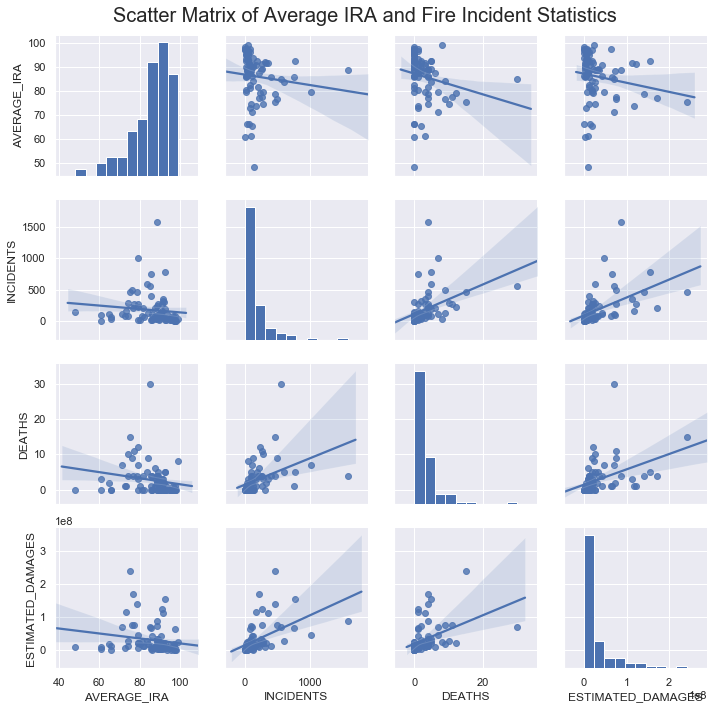

In [129]:
# We make a new IRA dataframe that contains only the provinces and the average IRA from 2009-2014
df3_province = df3[['PROVINCE']].copy()
df3_province['AVERAGE_IRA'] = df3.loc[: , '2009':'2014'].mean(axis=1)

# Now we can merge IRA with the df_2016
merged_ira = df_2016.merge(df3_province,left_on='PROVINCE_FIRE_DISTRICT',right_on='PROVINCE')

# We now use scatterplot visualizations to observe possible correlations between 
# IRA and fire incident statistics
pp = sns.pairplot(merged_ira[['AVERAGE_IRA', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],kind="reg")
pp.fig.suptitle("Scatter Matrix of Average IRA and Fire Incident Statistics",fontsize=20)
pp.fig.subplots_adjust(top=0.94)

### Findings (IRA Data vs Fire Incident Data)
From the visualizations alone, it is difficult to determine if there is a relationship between the Average IRA with the other data from the Fire Incidents dataset. Although it somewhat resembles a positive correlation, there still exist several points thats diverge from the regression line. Statistical testing will be done to determine the nature of their relationship.

## Inferential Statistics
To confirm our observed inferences, we will be performing statistical tests to confirm any possible correlations between the variables.

We can perform statistical tests that can help answer the question:
##### Do areas with higher government funding deal with fires better?

For this, we will be comparing the Average IRA of each province with the Estimated Damages from fire incidents.

First we perform Kolmogorov-Smirnov tests of goodness of fit to see how the data distributed.

In [130]:
ks, p = stats.kstest(merged_ira['ESTIMATED_DAMAGES'], 'norm')
alpha = 0.05
print("--ESTIMATED DAMAGES--")
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis that the data follows a normal distribution can be rejected")
else:
    print("The null hypothesis that the data follows a normal distribution cannot be rejected")
    
ks, p = stats.kstest(merged_ira['AVERAGE_IRA'], 'norm')
print("--AVERAGE_IRA--")
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis that the data follows a normal distribution can be rejected")
else:
    print("TThe null hypothesis that the data follows a normal distribution cannot be rejected")

ks, p = stats.kstest(merged_ira['INCIDENTS'], 'norm')
print("--INCIDENTS--")
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis that the data follows a normal distribution can be rejected")
else:
    print("TThe null hypothesis that the data follows a normal distribution cannot be rejected")

--ESTIMATED DAMAGES--
p = 0
The null hypothesis that the data follows a normal distribution can be rejected
--AVERAGE_IRA--
p = 0
The null hypothesis that the data follows a normal distribution can be rejected
--INCIDENTS--
p = 0
The null hypothesis that the data follows a normal distribution can be rejected


## Step 1: State the hypotheses.

$H_0$:  Our null hypothesis states that there is no monotonic relationship between the Average IRA and the Estimated Damages due to fire incidents of a province

$H_a$:  Our alternative hypothesis states that there is a monotonic relationship between the Average IRA and the Estimated Damages due to fire incidents in a province 

## Step 2: Significance level $\alpha = 5%$

## Step 3: Statistical test: Spearman's Ranked Test

Given that our data does not follow a normal distribution, we use Spearman's ranked test to test the correlation of the data.


## Step 4: Formulate the decision rule

If the p-value < 0.05 from the ztest then we can successfully reject the null.

In [131]:
rho, p = stats.spearmanr(merged_ira['AVERAGE_IRA'], merged_ira['ESTIMATED_DAMAGES'])
alpha = 0.05
print("p = {:g}".format(p))
print('Rho = {:g}'.format(rho))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.00250894
Rho = -0.333421
The null hypothesis can be rejected


In [132]:
rho, p = stats.spearmanr(merged_ira['AVERAGE_IRA'], merged_ira['INCIDENTS'])
alpha = 0.05
print("p = {:g}".format(p))
print('Rho = {:g}'.format(rho))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.000215259
Rho = -0.402415
The null hypothesis can be rejected


In [133]:
rho, p = stats.spearmanr(merged_firetruck['VEHICLES'], merged_firetruck['DEATHS'])
alpha = 0.05
print("p = {:g}".format(p))
print('Rho = {:g}'.format(rho))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.20338e-17
Rho = 0.771563
The null hypothesis can be rejected


In [134]:
rho, p = stats.spearmanr(merged_firetruck['VEHICLES'], merged_firetruck['ESTIMATED_DAMAGES'])
alpha = 0.05
print("p = {:g}".format(p))
print('Rho = {:g}'.format(rho))
if p < alpha:  # null hypothesis: x follows a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 4.76734e-17
Rho = 0.766479
The null hypothesis can be rejected


### Findings (Statistical Testing)
CHOOCHOO

## Conclusion
CHOOCHOO

# --- END OF NOTEBOOK ---